UnZip the provided dataset

In [5]:
!unzip -q "/content/images-20260220T110203Z-1-001.zip" -d "/content/images_dataset"

In [2]:
!pip install timm albumentations -q

In [3]:
!pip install timm -q


  Multilabel Classification — Training
  Model       : ResNet18
  Device      : cuda
  Images dir  : /content/images_dataset/images
  Labels file : /content/labels.txt
  Max epochs  : 50  |  Batch size : 16
  Early stop  : patience=5 epochs
[WARNING] 3 image(s) not found on disk — skipping.

  Labels loaded : 972 images from '/content/labels.txt'
  Attribute   Positives  Negatives     NA
  --------------------------------------
  Attr1             786        106     80
  Attr2             710        171     91
  Attr3             464        416     92
  Attr4              68        812     92

[Split] Train: 777 samples  |  Val: 195 samples



model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

[Model] ResNet18 ready (backbone frozen).
        in_features=512 | Trainable params (head): 67,204 | Device: cuda

[Weights] pos_weight per attribute: [0.14, 0.25, 0.82, 11.57]

  Epoch 01 | Iter 010/49 | Batch Loss: 0.8314
  Epoch 01 | Iter 020/49 | Batch Loss: 0.7501
  Epoch 01 | Iter 030/49 | Batch Loss: 0.4064
  Epoch 01 | Iter 040/49 | Batch Loss: 1.1449
  Epoch 01 | Iter 049/49 | Batch Loss: 0.3616

───────────────────────────────────────────────────────
Epoch [01/50]  Train Loss: 0.6685  |  Val Loss: 0.5435
Val Accuracy  →  Attr1=76.9%  Attr2=43.3%  Attr3=44.8%  Attr4=68.8%
───────────────────────────────────────────────────────
  ✓ Best model saved (val_loss=0.5435, epoch=1)
  Epoch 02 | Iter 010/49 | Batch Loss: 0.5677
  Epoch 02 | Iter 020/49 | Batch Loss: 0.8571
  Epoch 02 | Iter 030/49 | Batch Loss: 0.8409
  Epoch 02 | Iter 040/49 | Batch Loss: 0.4327
  Epoch 02 | Iter 049/49 | Batch Loss: 0.3208

───────────────────────────────────────────────────────
Epoch [02/50]  Train

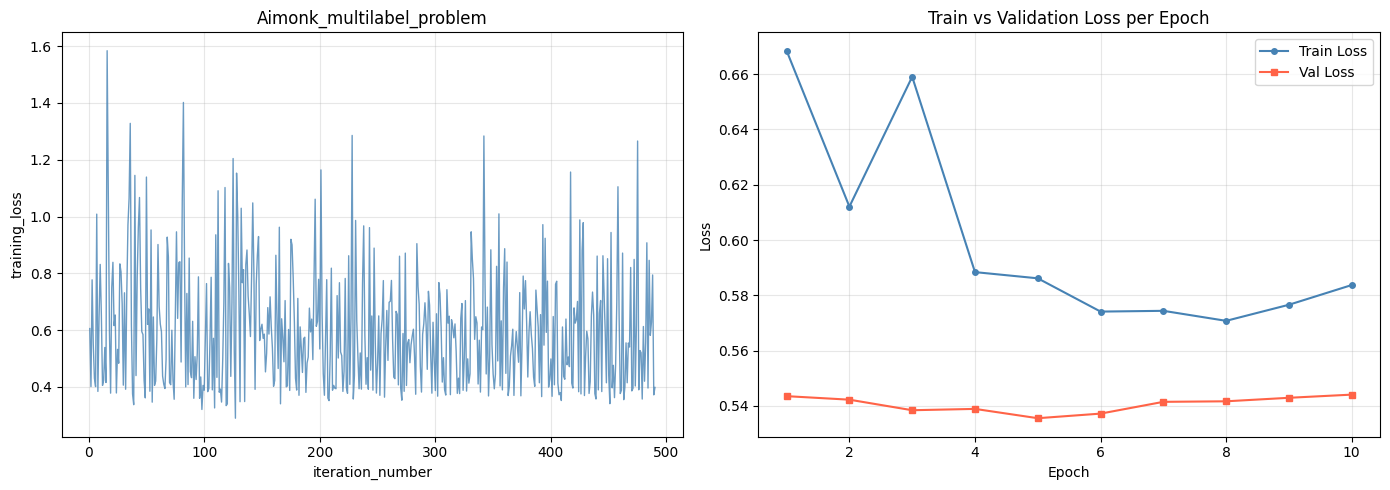


[Plot] Saved to '/content/loss_curve.png'

  Training complete!
  Best val loss : 0.5356
  Best epoch    : 5
  Model saved   : /content/multilabel_model.pth
  Loss curve    : /content/loss_curve.png



In [6]:
# dependencies
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import timm

IMAGES_DIR      = "/content/images_dataset/images"
LABELS_FILE     = "/content/labels.txt"                             #loading dataset
MODEL_SAVE      = "/content/multilabel_model.pth"
PLOT_SAVE       = "/content/loss_curve.png"

ATTR_COLS       = ["Attr1", "Attr2", "Attr3", "Attr4"]              #attributes
NUM_CLASSES     = 4
IMG_SIZE        = 224
BATCH_SIZE      = 16
NUM_EPOCHS      = 50
LR_HEAD         = 2e-3        # LR while backbone frozen
LR_FINETUNE     = 1e-4        # LR after partial unfreeze
THRESHOLD       = 0.5
UNFREEZE_EPOCH  = 3            # unfreeze last ResNet layer after this epoch
EARLY_STOP_PAT  = 5            # if val loss doesn't improve for this many epochs the process stops
DEVICE          = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. LABEL PARSING
def parse_labels(labels_file: str) -> pd.DataFrame:
    """
    Reads labels.txt (whitespace-separated).
    Auto-detects whether a header row exists.
    NA values become np.nan; 0/1 stay as float.
    """
    with open(labels_file, "r") as f:
        first_token = f.readline().strip().split()[0]
    has_header = not first_token.lower().endswith((".jpg", ".jpeg", ".png", ".bmp"))

    col_names = ["image_name"] + ATTR_COLS

    df = pd.read_csv(
        labels_file,
        sep=r"\s+",
        na_values=["NA"],
        dtype=str,
        engine="python",
        header=0 if has_header else None,
        names=None if has_header else col_names
    )

    if has_header:
        df.columns = [c.strip() for c in df.columns]
        df = df.rename(columns={df.columns[0]: "image_name"})

    for col in ATTR_COLS:
        if col not in df.columns:
            raise ValueError(
                f"Column '{col}' not found. Columns in file: {list(df.columns)}"
            )
        df[col] = pd.to_numeric(df[col], errors="coerce")
    missing = [
        row["image_name"] for _, row in df.iterrows()
        if not os.path.exists(os.path.join(IMAGES_DIR, row["image_name"]))
    ]
    if missing:
        print(f"[WARNING] {len(missing)} image(s) not found on disk — skipping.")
        df = df[~df["image_name"].isin(missing)].reset_index(drop=True)

    print(f"\n{'='*55}")
    print(f"  Labels loaded : {len(df)} images from '{labels_file}'")
    print(f"{'='*55}")
    print(f"  {'Attribute':<10} {'Positives':>10} {'Negatives':>10} {'NA':>6}")
    print(f"  {'-'*38}")
    for col in ATTR_COLS:
        pos = int((df[col] == 1.0).sum())
        neg = int((df[col] == 0.0).sum())
        na  = int(df[col].isna().sum())
        print(f"  {col:<10} {pos:>10} {neg:>10} {na:>6}")
    print(f"{'='*55}\n")

    return df
# 2. COMPUTE CLASS WEIGHTS  (handles imbalance)
def compute_pos_weights(df: pd.DataFrame) -> torch.Tensor:
    """
    pos_weight[j] = (#negatives_j) / (#positives_j)
    Passed to BCEWithLogitsLoss — rare positives get higher penalty when missed.
    """
    pos_weights = []
    for col in ATTR_COLS:
        n_pos = max(int((df[col] == 1.0).sum()), 1)
        n_neg = max(int((df[col] == 0.0).sum()), 1)
        pos_weights.append(n_neg / n_pos)

    weights = torch.tensor(pos_weights, dtype=torch.float32)
    print(f"[Weights] pos_weight per attribute: "
          f"{[round(w, 2) for w in weights.tolist()]}\n")
    return weights

# 3. DATASET
class MultilabelDataset(Dataset):
    def __init__(self, df: pd.DataFrame, images_dir: str, transform=None):
        self.df         = df.reset_index(drop=True)
        self.images_dir = images_dir
        self.transform  = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row      = self.df.iloc[idx]
        img_path = os.path.join(self.images_dir, row["image_name"])

        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            raise FileNotFoundError(f"Cannot open image: {img_path}") from e

        if self.transform:
            image = self.transform(image)
        raw    = row[ATTR_COLS].values.astype(np.float32)
        mask   = ~np.isnan(raw)
        labels = np.where(np.isnan(raw), 0.0, raw)

        return (
            image,
            torch.tensor(labels, dtype=torch.float32),
            torch.tensor(mask,   dtype=torch.bool)
        )

# 4. TRANSFORMS / AUGMENTATION
def get_transforms(train: bool) -> transforms.Compose:
    mean = [0.485, 0.456, 0.406]
    std  = [0.229, 0.224, 0.225]

    if train:
        return transforms.Compose([
            transforms.Resize((IMG_SIZE + 24, IMG_SIZE + 24)),
            transforms.RandomCrop(IMG_SIZE),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.2),
            transforms.ColorJitter(brightness=0.3, contrast=0.3,
                                   saturation=0.2, hue=0.1),
            transforms.RandomRotation(15),
            transforms.RandomGrayscale(p=0.05),
            transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std),
            transforms.RandomErasing(p=0.3, scale=(0.02, 0.15)),
        ])
    else:
        return transforms.Compose([
            transforms.Resize((IMG_SIZE, IMG_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std),
        ])

# 5. MODEL  — ResNet18
def build_model(num_classes: int) -> nn.Module:

    model       = timm.create_model("resnet18", pretrained=True, num_classes=0)
    in_features = model.num_features    # 512 for ResNet18

    # Freeze all backbone layers
    for param in model.parameters():
        param.requires_grad = False

    model.fc = nn.Sequential(
        nn.BatchNorm1d(in_features),
        nn.Dropout(p=0.5),
        nn.Linear(in_features, 128),
        nn.ReLU(),
        nn.Dropout(p=0.3),
        nn.Linear(128, num_classes)
    )

    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"[Model] ResNet18 ready (backbone frozen).")
    print(f"        in_features={in_features} | "
          f"Trainable params (head): {trainable:,} | Device: {DEVICE}\n")
    return model


def unfreeze_last_layer(model: nn.Module):
    """
    Unfreeze only layer4 (the last ResNet block) + the head.
    layer4 = ~1.3M params — enough flexibility without causing overfitting.
    Earlier layers (edges/textures/shapes) stay frozen — ImageNet handles those well.
    """
    for name, param in model.named_parameters():
        if "layer4" in name:
            param.requires_grad = True

    total = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\n[Model] layer4 UNFROZEN — total trainable params: {total:,}")

class EarlyStopping:
    """
    Stops training when val loss hasn't improved for `patience` epochs.
    Saves the best model automatically.

    patience=7 means: if val loss doesn't improve for 7 consecutive epochs → stop.
    This prevents wasting Colab GPU time on epochs that won't help.
    """
    def __init__(self, patience: int = 7, model_save: str = MODEL_SAVE):
        self.patience   = patience
        self.model_save = model_save
        self.best_loss  = float("inf")
        self.counter    = 0
        self.best_epoch = 0

    def step(self, val_loss: float, model: nn.Module, epoch: int) -> bool:
        """
        Returns True if training should STOP.
        Saves model checkpoint whenever val loss improves.
        """
        if val_loss < self.best_loss:
            self.best_loss  = val_loss
            self.counter    = 0
            self.best_epoch = epoch + 1
            torch.save({
                "epoch":       epoch + 1,
                "model_state": model.state_dict(),
                "val_loss":    val_loss,
                "attr_cols":   ATTR_COLS,
                "threshold":   THRESHOLD,
                "img_size":    IMG_SIZE,
            }, self.model_save)
            print(f"  ✓ Best model saved (val_loss={val_loss:.4f}, epoch={epoch+1})")
            return False   # don't stop
        else:
            self.counter += 1
            print(f"  [EarlyStopping] No improvement for {self.counter}/{self.patience} epochs "
                  f"(best={self.best_loss:.4f} @ epoch {self.best_epoch})")
            return self.counter >= self.patience

# 7. MASKED BCE LOSS  (handles NA labels)
class MaskedBCEWithLogitsLoss(nn.Module):
    """
    BCEWithLogitsLoss that ignores NA label positions.
    1. Element-wise BCE → shape (B, num_classes)
    2. Zero out NA positions via mask
    3. Average over known labels only
    pos_weight handles class imbalance.
    """
    def __init__(self, pos_weight: torch.Tensor = None):
        super().__init__()
        self.pos_weight = pos_weight

    def forward(self,
                logits: torch.Tensor,
                labels: torch.Tensor,
                mask:   torch.Tensor) -> torch.Tensor:

        pw = self.pos_weight.to(logits.device) if self.pos_weight is not None else None

        loss_matrix = nn.functional.binary_cross_entropy_with_logits(
            logits, labels, pos_weight=pw, reduction="none"
        )
        loss_matrix = loss_matrix * mask.float()

        n_known = mask.float().sum()
        if n_known == 0:
            return torch.tensor(0.0, requires_grad=True, device=logits.device)
        return loss_matrix.sum() / n_known


# 8. TRAINING — one epoch
def train_one_epoch(model, loader, criterion, optimizer, epoch):
    model.train()
    total_loss       = 0.0
    iteration_losses = []

    for i, (images, labels, masks) in enumerate(loader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        masks  = masks.to(DEVICE)

        optimizer.zero_grad()
        logits = model(images)
        loss   = criterion(logits, labels, masks)
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        iteration_losses.append(loss.item())

        if (i + 1) % 10 == 0 or (i + 1) == len(loader):
            print(f"  Epoch {epoch+1:02d} | Iter {i+1:03d}/{len(loader)} "
                  f"| Batch Loss: {loss.item():.4f}")

    return total_loss / len(loader), iteration_losses

# 9. VALIDATION
@torch.no_grad()
def validate(model, loader, criterion):
    """Returns avg val loss and per-attribute accuracy (known labels only)."""
    model.eval()
    total_loss = 0.0
    all_preds  = []
    all_labels = []
    all_masks  = []

    for images, labels, masks in loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        masks  = masks.to(DEVICE)

        logits = model(images)
        loss   = criterion(logits, labels, masks)
        total_loss += loss.item()

        preds = (torch.sigmoid(logits) >= THRESHOLD).float()
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())
        all_masks.append(masks.cpu())

    avg_loss   = total_loss / len(loader)
    all_preds  = torch.cat(all_preds,  dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    all_masks  = torch.cat(all_masks,  dim=0)

    attr_acc = {}
    for j, col in enumerate(ATTR_COLS):
        known = all_masks[:, j]
        if known.sum() == 0:
            attr_acc[col] = float("nan")
        else:
            correct = (all_preds[known, j] == all_labels[known, j]).float()
            attr_acc[col] = correct.mean().item()

    return avg_loss, attr_acc


# 10. PLOT LOSS CURVE
def plot_loss_curve(all_iter_losses, train_epoch_losses, val_epoch_losses,
                    stopped_at: int = None, save_path: str = PLOT_SAVE):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Left: iteration-level training loss (required by task spec)
    axes[0].plot(range(1, len(all_iter_losses) + 1), all_iter_losses,
                 linewidth=1.0, color="steelblue", alpha=0.8)
    axes[0].set_xlabel("iteration_number")
    axes[0].set_ylabel("training_loss")
    axes[0].set_title("Aimonk_multilabel_problem")
    axes[0].grid(True, alpha=0.3)
    epochs = range(1, len(train_epoch_losses) + 1)
    axes[1].plot(epochs, train_epoch_losses, label="Train Loss",
                 color="steelblue", marker="o", markersize=4)
    axes[1].plot(epochs, val_epoch_losses,   label="Val Loss",
                 color="tomato",    marker="s", markersize=4)

    if stopped_at and stopped_at < len(train_epoch_losses):
        axes[1].axvline(x=stopped_at, color="gray", linestyle="--", alpha=0.7,
                        label=f"Early stop (epoch {stopped_at})")

    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Loss")
    axes[1].set_title("Train vs Validation Loss per Epoch")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.show()
    print(f"\n[Plot] Saved to '{save_path}'")



# 11. MAIN

def main():
    print(f"\n{'='*55}")
    print(f"  Multilabel Classification — Training")
    print(f"  Model       : ResNet18")
    print(f"  Device      : {DEVICE}")
    print(f"  Images dir  : {IMAGES_DIR}")
    print(f"  Labels file : {LABELS_FILE}")
    print(f"  Max epochs  : {NUM_EPOCHS}  |  Batch size : {BATCH_SIZE}")
    print(f"  Early stop  : patience={EARLY_STOP_PAT} epochs")
    print(f"{'='*55}")

    #  Parse labels
    df = parse_labels(LABELS_FILE)

    #  Train / Val split (80 / 20)
    df       = df.sample(frac=1, random_state=42).reset_index(drop=True)
    split    = int(0.8 * len(df))
    train_df = df.iloc[:split]
    val_df   = df.iloc[split:]
    print(f"[Split] Train: {len(train_df)} samples  |  Val: {len(val_df)} samples\n")

    #  Datasets & DataLoaders
    train_ds = MultilabelDataset(train_df, IMAGES_DIR, get_transforms(train=True))
    val_ds   = MultilabelDataset(val_df,   IMAGES_DIR, get_transforms(train=False))

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE,
                              shuffle=True,  num_workers=2, pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE,
                              shuffle=False, num_workers=2, pin_memory=True)

    #  Model
    model = build_model(NUM_CLASSES).to(DEVICE)

    #  Loss
    pos_weights = compute_pos_weights(train_df)
    criterion   = MaskedBCEWithLogitsLoss(pos_weight=pos_weights)

    # Early stopping
    early_stopping = EarlyStopping(patience=EARLY_STOP_PAT, model_save=MODEL_SAVE)

    #  Optimizer: head only initially
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=LR_HEAD, weight_decay=1e-3
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=3, factor=0.5
    )

    #  Training Loop
    all_iter_losses    = []
    train_epoch_losses = []
    val_epoch_losses   = []
    stopped_at         = None

    for epoch in range(NUM_EPOCHS):

        # Stage 2: unfreeze layer4 after UNFREEZE_EPOCH
        if epoch == UNFREEZE_EPOCH:
            unfreeze_last_layer(model)
            optimizer = torch.optim.Adam(
                filter(lambda p: p.requires_grad, model.parameters()),
                lr=LR_FINETUNE, weight_decay=1e-3
            )
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode="min", patience=3, factor=0.5
            )

        #Train
        train_loss, iter_losses = train_one_epoch(
            model, train_loader, criterion, optimizer, epoch
        )
        all_iter_losses.extend(iter_losses)
        train_epoch_losses.append(train_loss)

        #  Validate
        val_loss, attr_acc = validate(model, val_loader, criterion)
        val_epoch_losses.append(val_loss)
        scheduler.step(val_loss)

        #  Log
        acc_str = "  ".join(
            f"{col}={v:.1%}" if not np.isnan(v) else f"{col}=N/A"
            for col, v in attr_acc.items()
        )
        print(f"\n{'─'*55}")
        print(f"Epoch [{epoch+1:02d}/{NUM_EPOCHS}]  "
              f"Train Loss: {train_loss:.4f}  |  Val Loss: {val_loss:.4f}")
        print(f"Val Accuracy  →  {acc_str}")
        print(f"{'─'*55}")

        # Early stopping check
        should_stop = early_stopping.step(val_loss, model, epoch)
        if should_stop:
            stopped_at = epoch + 1
            print(f"\n[EarlyStopping] Triggered at epoch {stopped_at}. "
                  f"Best val loss: {early_stopping.best_loss:.4f} "
                  f"@ epoch {early_stopping.best_epoch}")
            break

    # Plot
    plot_loss_curve(all_iter_losses, train_epoch_losses, val_epoch_losses,
                    stopped_at=stopped_at)

    print(f"\n{'='*55}")
    print(f"  Training complete!")
    print(f"  Best val loss : {early_stopping.best_loss:.4f}")
    print(f"  Best epoch    : {early_stopping.best_epoch}")
    print(f"  Model saved   : {MODEL_SAVE}")
    print(f"  Loss curve    : {PLOT_SAVE}")
    print(f"{'='*55}\n")


if __name__ == "__main__":
    main()

Inference(replace image path with your image)

In [ ]:
import sys
import torch
import torch.nn as nn
from PIL import Image
import torchvision.transforms as transforms
import timm

IMAGE_PATH = "/content/file_address.jpg"
MODEL_PATH = "/content/multilabel_model.pth"              #model was created after finetuning it with dataset


def build_model(num_classes: int) -> nn.Module:
    model       = timm.create_model("resnet18", pretrained=False, num_classes=0)
    in_features = model.num_features    # 512 for ResNet18
    model.fc = nn.Sequential(
        nn.BatchNorm1d(in_features),
        nn.Dropout(p=0.5),
        nn.Linear(in_features, 128),
        nn.ReLU(),
        nn.Dropout(p=0.3),
        nn.Linear(128, num_classes)
    )
    return model


#Load model
def load_model(model_path: str, device: torch.device):
    checkpoint  = torch.load(model_path, map_location=device)
    attr_cols   = checkpoint.get("attr_cols",  ["Attr1", "Attr2", "Attr3", "Attr4"])
    threshold   = checkpoint.get("threshold",  0.5)
    img_size    = checkpoint.get("img_size",   224)
    num_classes = len(attr_cols)

    model = build_model(num_classes).to(device)
    model.load_state_dict(checkpoint["model_state"])
    model.eval()

    print(f"[Model] ResNet18 loaded from '{model_path}'")
    print(f"        Epoch {checkpoint.get('epoch', '?')} | "
          f"val_loss = {checkpoint.get('val_loss', float('nan')):.4f}")
    return model, attr_cols, threshold, img_size


#Predict

def predict(image_path: str, model_path: str = MODEL_PATH) -> list:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model, attr_cols, threshold, img_size = load_model(model_path, device)

    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

    image  = Image.open(image_path).convert("RGB")
    tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(tensor)
        probs  = torch.sigmoid(logits).squeeze(0)

    #  Print results
    present_attrs = []
    print(f"\n{'─'*50}")
    print(f"  Image : {image_path}")
    print(f"{'─'*50}")
    print(f"  {'Attribute':<10} {'Probability':>12}   Status")
    print(f"  {'─'*42}")
    for attr, prob in zip(attr_cols, probs.tolist()):
        print(f"  {attr:<10} {prob:>11.4f}   "
              f"{'[PRESENT]' if prob >= threshold else '[absent] '}")
        if prob >= threshold:
            present_attrs.append(attr)

    print(f"{'─'*50}")
    if present_attrs:
        print(f"  Attributes present : {present_attrs}")
    else:
        print("  No attributes detected above threshold.")
    print(f"{'─'*50}\n")

    return present_attrs



# ENTRY POINT — works as Colab cell OR CLI script
if __name__ == "__main__":
    # Strip Colab kernel flags like -f /path/to/kernel.json
    clean_argv = [a for a in sys.argv[1:]
                  if not a.startswith("-f") and "kernel" not in a]

    if not clean_argv:
        # No CLI args → use IMAGE_PATH / MODEL_PATH set at the top
        predict(IMAGE_PATH, MODEL_PATH)
    else:
        import argparse
        parser = argparse.ArgumentParser(description="Multilabel Classification Inference")
        parser.add_argument("--image", type=str, required=True,
                            help="Path to input image")
        parser.add_argument("--model", type=str, default=MODEL_PATH,
                            help="Path to model checkpoint")
        args = parser.parse_args(clean_argv)
        predict(args.image, args.model)